# Volume 3: Speech Recognition using CDHMMs
    Daniel Perkins
    MATH 405
    1/21/25

In [52]:
import os
import MFCC
import re

import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [55]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size=(5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    

    # Variables to store things
    states = np.empty(T)
    obs = np.empty((T, M))

    # Initial draw  
    X = np.random.choice(N, p=pi)  # Determine the hidden state
    states[0] = X
    Y = np.random.choice(K, p=weights[X])   # Determine GMM component Y
    Z = multivariate_normal.rvs(mean=means[X, Y], cov=covars[X, Y])  # Sample Z from normal
    obs[0] = Z
    
    # Do it for the rest of t
    for t in range(1, T):
        X = np.random.choice(N, p=A[X])  # Choose the next random state
        states[t] = X
        Y = np.random.choice(K, p=weights[X])   # Determine GMM component Y
        Z = multivariate_normal.rvs(mean=means[X, Y], cov=covars[X, Y])  # Sample Z from normal
        obs[t] = Z
        
    return states, obs

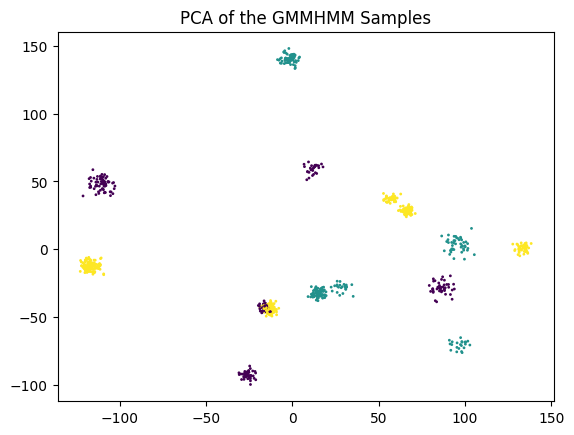

In [78]:
states, obs = sample_gmmhmm(T=900)

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
obs_reduced = pca.fit_transform(obs)

X, Y = obs_reduced.T

plt.title("PCA of the GMMHMM Samples")
plt.scatter(X, Y, c=states, cmap='viridis', s=1)
plt.show()

There appears to be 14 different clusters. ALl but one of them contain points of just one class.

## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?